In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [ ]:
df = pd.read_csv("AMGN_1min.csv",header= None, names = ['Date','Open','High','Low','Close','Volume'])
df.head()


,Date,Open,High,Low,Close,Volume
0,2005-01-03 08:38:00,49.2303,49.2303,49.2303,49.2303,100
1,2005-01-03 08:41:00,49.2303,49.2303,49.1843,49.1843,600
2,2005-01-03 08:42:00,49.2303,49.2303,49.2303,49.2303,200
3,2005-01-03 08:50:00,49.2610,49.3070,49.2610,49.3070,1000
4,2005-01-03 09:15:00,49.2686,49.2686,49.2686,49.2686,708


In [ ]:
df = df[['Date','Close']]
df
type(df)

pandas.core.frame.DataFrame

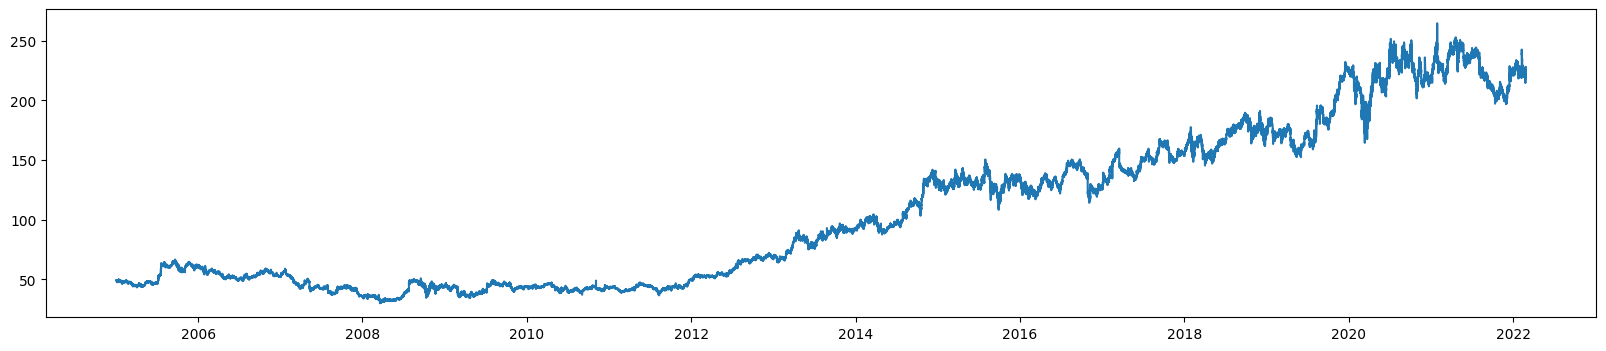

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
plt.figure(figsize=(20, 4))
plt.plot(df['Date'],df['Close'])

In [ ]:
from copy import deepcopy as dc
def prep_df_for_LSTM(df,n_steps):
    df = dc(df)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date',inplace = True)
    for i in range(1,n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
    df.dropna(inplace = True)
    df = df['2005-01-03 08:38:00':'2005-01-03 21:38:00']
    return df

lookback = 7
shifted_df = prep_df_for_LSTM(df,lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2005-01-03 09:26:00,49.2686,49.2686,49.2686,49.2686,49.3070,49.2303,49.1843,49.2303
2005-01-03 09:28:00,49.1843,49.2686,49.2686,49.2686,49.2686,49.3070,49.2303,49.1843
2005-01-03 09:29:00,49.1919,49.1843,49.2686,49.2686,49.2686,49.2686,49.3070,49.2303
2005-01-03 09:30:00,49.2073,49.1919,49.1843,49.2686,49.2686,49.2686,49.2686,49.3070
2005-01-03 09:31:00,49.3223,49.2073,49.1919,49.1843,49.2686,49.2686,49.2686,49.2686
...,...,...,...,...,...,...,...,...
2005-01-03 17:02:00,49.4526,49.2993,49.2993,49.2993,49.2993,49.1843,49.2993,49.2993
2005-01-03 17:06:00,49.4526,49.4526,49.2993,49.2993,49.2993,49.2993,49.1843,49.2993
2005-01-03 17:16:00,49.4526,49.4526,49.4526,49.2993,49.2993,49.2993,49.2993,49.1843


In [ ]:
type(shifted_df)

pandas.core.frame.DataFrame

In [ ]:
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[49.2686, 49.2686, 49.2686, ..., 49.2303, 49.1843, 49.2303],
       [49.1843, 49.2686, 49.2686, ..., 49.307 , 49.2303, 49.1843],
       [49.1919, 49.1843, 49.2686, ..., 49.2686, 49.307 , 49.2303],
       ...,
       [49.4526, 49.4526, 49.4526, ..., 49.2993, 49.2993, 49.1843],
       [49.1843, 49.4526, 49.4526, ..., 49.2993, 49.2993, 49.2993],
       [49.1843, 49.1843, 49.4526, ..., 49.2993, 49.2993, 49.2993]])

In [ ]:
len(shifted_df_as_np)

413

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler(feature_range = (-1,1))
shifted_df_as_np = scalar.fit_transform(shifted_df_as_np)
shifted_df_as_np

array([[ 0.18801653,  0.18801653,  0.18801653, ...,  0.08910124,
        -0.02970041,  0.08910124],
       [-0.02970041,  0.18801653,  0.18801653, ...,  0.28719008,
         0.08910124, -0.02970041],
       [-0.01007231, -0.02970041,  0.18801653, ...,  0.18801653,
         0.28719008,  0.08910124],
       ...,
       [ 0.66322314,  0.66322314,  0.66322314, ...,  0.26730372,
         0.26730372, -0.02970041],
       [-0.02970041,  0.66322314,  0.66322314, ...,  0.26730372,
         0.26730372,  0.26730372],
       [-0.02970041, -0.02970041,  0.66322314, ...,  0.26730372,
         0.26730372,  0.26730372]])

In [ ]:
x = shifted_df_as_np[:,1:]
y = shifted_df_as_np[:,0]
x.shape,y.shape

((413, 7), (413,))

In [ ]:
x = dc(np.flip(x,axis = 1))
x

array([[ 0.08910124, -0.02970041,  0.08910124, ...,  0.18801653,
         0.18801653,  0.18801653],
       [-0.02970041,  0.08910124,  0.28719008, ...,  0.18801653,
         0.18801653,  0.18801653],
       [ 0.08910124,  0.28719008,  0.18801653, ...,  0.18801653,
         0.18801653, -0.02970041],
       ...,
       [-0.02970041,  0.26730372,  0.26730372, ...,  0.26730372,
         0.66322314,  0.66322314],
       [ 0.26730372,  0.26730372,  0.26730372, ...,  0.66322314,
         0.66322314,  0.66322314],
       [ 0.26730372,  0.26730372,  0.26730372, ...,  0.66322314,
         0.66322314, -0.02970041]])

In [ ]:
split_index = int(len(x)*0.90)  # first 90% train

split_index

371

In [ ]:
x_train = x[:split_index]
x_test = x[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((371, 7), (42, 7), (371,), (42,))

#### For LSTM the data needs to have one extra dim

In [ ]:
x_train = x_train.reshape((-1, lookback, 1))
x_test = x_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((371, 7, 1), (42, 7, 1), (371, 1), (42, 1))

In [ ]:
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()
x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float()

x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([371, 7, 1]),
 torch.Size([42, 7, 1]),
 torch.Size([371, 1]),
 torch.Size([42, 1]))

In [ ]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

train_dataset = TimeSeriesDataset(x_train, y_train)
test_dataset = TimeSeriesDataset(x_test, y_test)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([8, 7, 1]) torch.Size([8, 1])


In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).requires_grad_().to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).requires_grad_().to(device)

        out, (hn,cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 8, 2)    # only one input cuz only Close feature hidden size can be anything
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 8, num_layers=2, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)

In [ ]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [ ]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [ ]:
learning_rate = 0.001
num_epochs = 200
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.139
***************************************************

Epoch: 2

Val Loss: 0.096
***************************************************

Epoch: 3

Val Loss: 0.076
***************************************************

Epoch: 4

Val Loss: 0.072
***************************************************

Epoch: 5

Val Loss: 0.081
***************************************************

Epoch: 6

Val Loss: 0.083
***************************************************

Epoch: 7

Val Loss: 0.082
***************************************************

Epoch: 8

Val Loss: 0.080
***************************************************

Epoch: 9

Val Loss: 0.079
***************************************************

Epoch: 10

Val Loss: 0.077
***************************************************

Epoch: 11

Val Loss: 0.080
***************************************************

Epoch: 12

Val Loss: 0.075
***************************************************

Epoch: 13

Val Loss: 0.080
**********************

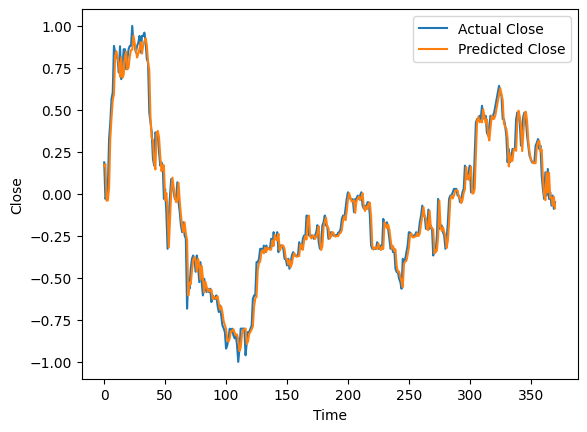

In [ ]:
with torch.no_grad():
    predicted = model(x_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
train_predictions = predicted.flatten()

dummies = np.zeros((x_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scalar.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([49.26042348, 49.26484809, 49.17998356, 49.18100829, 49.20916331,
       49.32285402, 49.37046993, 49.41093258, 49.42591459, 49.51288121,
       49.52489961, 49.5104553 , 49.49608692, 49.46587481, 49.51032361,
       49.46383092, 49.47069138, 49.51179457, 49.52357368, 49.48279955,
       49.48711568, 49.5129787 , 49.52725103, 49.52839389, 49.56067738,
       49.54368769, 49.5270303 , 49.510096  , 49.51888986, 49.53057721,
       49.54555081, 49.51927112, 49.53780617, 49.54754713, 49.55457116,
       49.53853768, 49.50018453, 49.48154831, 49.37079454, 49.32433993,
       49.32048148, 49.26905565, 49.25216943, 49.33675793, 49.34091703,
       49.32626873, 49.28274147, 49.24852168, 49.26182837, 49.26167393,
       49.18129424, 49.19777519, 49.15758158, 49.07247678, 49.13825328,
       49.19938309, 49.23332914, 49.21196559, 49.18905551, 49.17678788,
       49.18072685, 49.22128109, 49.17893635, 49.1462889 , 49.12067555,
       49.10772689, 49.13006183, 49.10423893, 49.09026121, 48.96

In [ ]:
dummies = np.zeros((x_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scalar.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([49.2686    , 49.1843    , 49.1919    , 49.2073    , 49.32229999,
       49.3606    , 49.41430001, 49.42959999, 49.537     , 49.52159999,
       49.51400001, 49.50630001, 49.47559999, 49.53619999, 49.46030001,
       49.491     , 49.5293    , 49.5293    , 49.4833    , 49.50630001,
       49.5293    , 49.537     , 49.537     , 49.583     , 49.5446    ,
       49.537     , 49.52159999, 49.537     , 49.5446    , 49.56000001,
       49.52159999, 49.56000001, 49.56000001, 49.56759999, 49.5446    ,
       49.50630001, 49.4986    , 49.3836    , 49.3606    , 49.3376    ,
       49.2763    , 49.261     , 49.3376    , 49.33      , 49.33      ,
       49.2916    , 49.261     , 49.2686    , 49.261     , 49.1843    ,
       49.2073    , 49.1536    , 49.06930001, 49.1459    , 49.1919    ,
       49.2303    , 49.215     , 49.1996    , 49.1843    , 49.1843    ,
       49.2226    , 49.1766    , 49.1536    , 49.1229    , 49.1076    ,
       49.1306    , 49.0999    , 49.09230001, 48.93129999, 49.00

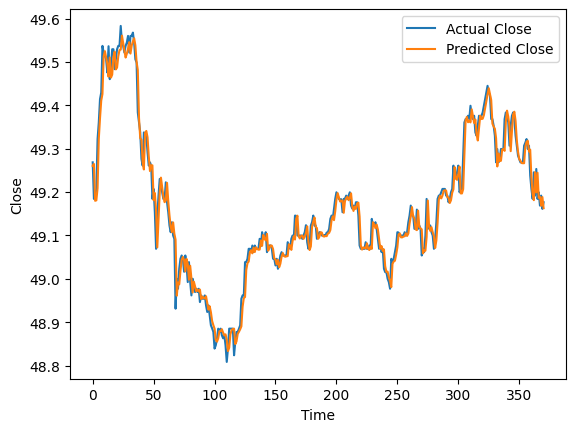

In [ ]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
test_predictions = model(x_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((x_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scalar.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([49.17207218, 49.18737891, 49.1758053 , 49.20237488, 49.18418619,
       49.22379848, 49.238939  , 49.25745598, 49.18786708, 49.18725939,
       49.08223133, 49.08670184, 49.11215455, 49.09076081, 49.22044113,
       49.15686254, 49.0881023 , 49.07204049, 49.14141024, 49.15957464,
       49.18867486, 49.23435782, 49.32541305, 49.32615589, 49.34243062,
       49.34622719, 49.34536258, 49.36862367, 49.29504517, 49.28197576,
       49.41877771, 49.31651818, 49.2754459 , 49.17210691, 49.28710124,
       49.31523804, 49.29969319, 49.29160177, 49.4350681 , 49.46553107,
       49.45234422, 49.16843054])

In [ ]:
dummies = np.zeros((x_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scalar.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([49.1881    , 49.1766    , 49.2073    , 49.1843    , 49.2303    ,
       49.238     , 49.261     , 49.1919    , 49.1996    , 49.0769    ,
       49.09230001, 49.1076    , 49.0846    , 49.2303    , 49.1452    ,
       49.0999    , 49.0769    , 49.1459    , 49.1536    , 49.1919    ,
       49.238     , 49.33      , 49.32229999, 49.353     , 49.353     ,
       49.353     , 49.376     , 49.29929999, 49.29929999, 49.42959999,
       49.29929999, 49.29929999, 49.1843    , 49.29929999, 49.29929999,
       49.29929999, 49.29929999, 49.4526    , 49.4526    , 49.4526    ,
       49.1843    , 49.1843    ])

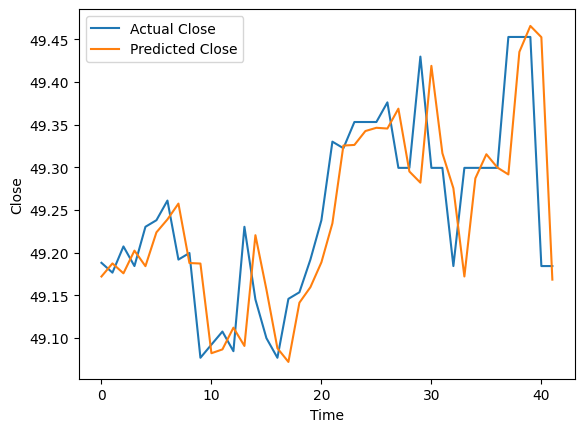

In [ ]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.show()


In [ ]:
print(shifted_df)

                       Close  Close(t-1)  Close(t-2)  Close(t-3)  Close(t-4)  \
Date                                                                           
2005-01-03 15:38:00  49.1881     49.1766     49.1613     49.1919     49.1689   
2005-01-03 15:39:00  49.1766     49.1881     49.1766     49.1613     49.1919   
2005-01-03 15:40:00  49.2073     49.1766     49.1881     49.1766     49.1613   
2005-01-03 15:41:00  49.1843     49.2073     49.1766     49.1881     49.1766   
2005-01-03 15:42:00  49.2303     49.1843     49.2073     49.1766     49.1881   
2005-01-03 15:43:00  49.2380     49.2303     49.1843     49.2073     49.1766   
2005-01-03 15:44:00  49.2610     49.2380     49.2303     49.1843     49.2073   
2005-01-03 15:45:00  49.1919     49.2610     49.2380     49.2303     49.1843   
2005-01-03 15:46:00  49.1996     49.1919     49.2610     49.2380     49.2303   
2005-01-03 15:47:00  49.0769     49.1996     49.1919     49.2610     49.2380   
2005-01-03 15:48:00  49.0923     49.0769

In [ ]:
shifted_df = shifted_df["2005-01-03 15:38:00":]
shifted_df['prediction'] = test_predictions
shifted_df

C:\Users\Swapnil Banthia\AppData\Local\Temp\ipykernel_7004\1561903894.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shifted_df['prediction'] = test_predictions


,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),prediction
Date,,,,,,,,,
2005-01-03 15:38:00,49.1881,49.1766,49.1613,49.1919,49.1689,49.1996,49.1843,49.2533,49.172072
2005-01-03 15:39:00,49.1766,49.1881,49.1766,49.1613,49.1919,49.1689,49.1996,49.1843,49.187379
2005-01-03 15:40:00,49.2073,49.1766,49.1881,49.1766,49.1613,49.1919,49.1689,49.1996,49.175805
2005-01-03 15:41:00,49.1843,49.2073,49.1766,49.1881,49.1766,49.1613,49.1919,49.1689,49.202375
2005-01-03 15:42:00,49.2303,49.1843,49.2073,49.1766,49.1881,49.1766,49.1613,49.1919,49.184186
2005-01-03 15:43:00,49.2380,49.2303,49.1843,49.2073,49.1766,49.1881,49.1766,49.1613,49.223798
2005-01-03 15:44:00,49.2610,49.2380,49.2303,49.1843,49.2073,49.1766,49.1881,49.1766,49.238939
2005-01-03 15:45:00,49.1919,49.2610,49.2380,49.2303,49.1843,49.2073,49.1766,49.1881,49.257456
2005-01-03 15:46:00,49.1996,49.1919,49.2610,49.2380,49.2303,49.1843,49.2073,49.1766,49.187867


In [ ]:
shifted_df.columns
columns =  ['Close','prediction']
df = shifted_df[columns]
df

,Close,prediction
Date,,
2005-01-03 15:38:00,49.1881,49.172072
2005-01-03 15:39:00,49.1766,49.187379
2005-01-03 15:40:00,49.2073,49.175805
2005-01-03 15:41:00,49.1843,49.202375
2005-01-03 15:42:00,49.2303,49.184186
2005-01-03 15:43:00,49.2380,49.223798
2005-01-03 15:44:00,49.2610,49.238939
2005-01-03 15:45:00,49.1919,49.257456
2005-01-03 15:46:00,49.1996,49.187867


In [ ]:
type(df)

pandas.core.frame.DataFrame

In [ ]:
test_range = df.iloc[split_index:]
test_range

,Close,prediction
Date,,


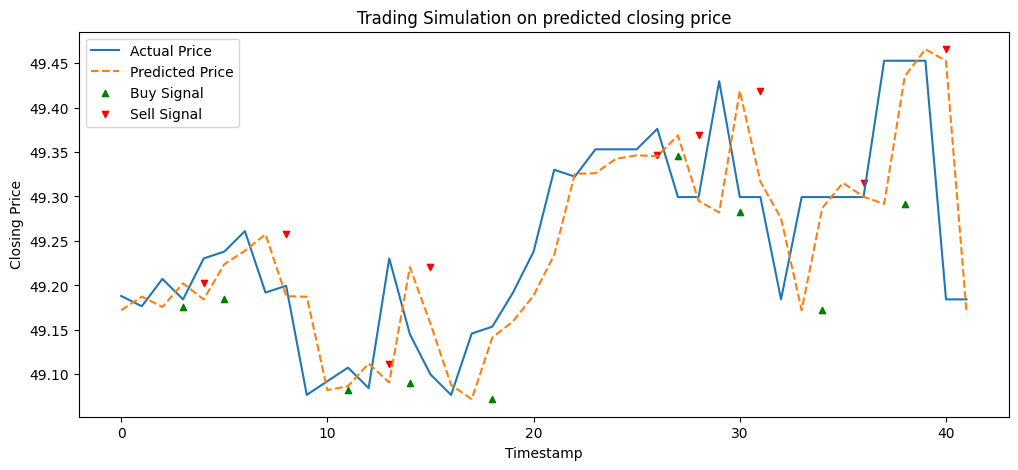

Initial Balance Predicted: $49.20
Final Balance Predicted: $49.35
Final Profit Predicted: $0.15
Returns Predicted: 0.30%



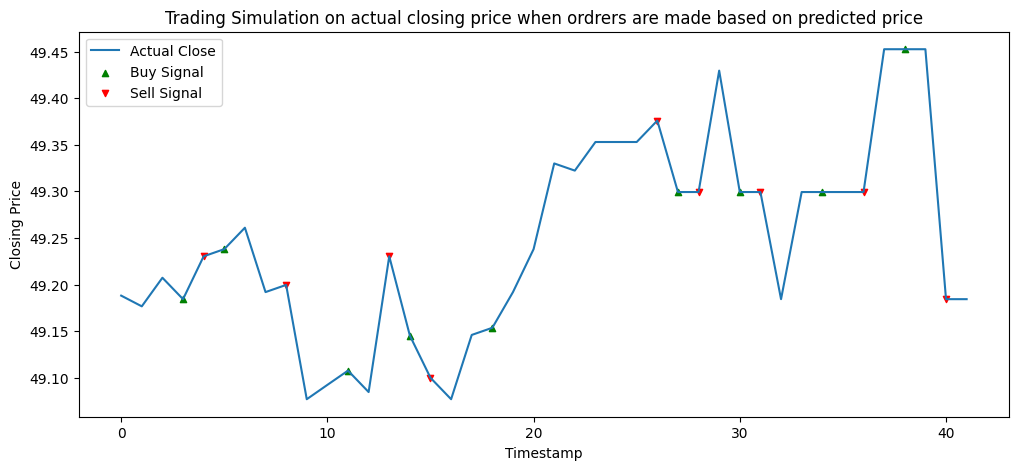

Initial Balance: $49.18
Final Balance: $49.22
Final Profit: $0.04
Returns: 0.08%



In [ ]:
def strat(data_frame):
    signals = pd.DataFrame(index=data_frame.index)
    signals['Price'] = data_frame['Close']
    signals['Predicted_Price'] = data_frame['prediction']

    action = 'x'
    profit_actual = 0
    prev_price = 0
    first_investment = 0

    profit_pred = 0
    first_investment_pred = 0
    prev_price_pred = 0

    buy_signals = np.nan * np.zeros(data_frame.shape[0])    # initilization for plotting graph
    sell_signals = np.nan * np.zeros(data_frame.shape[0])
    buy_signals_actual = np.nan * np.zeros(data_frame.shape[0])
    sell_signals_actual = np.nan * np.zeros(data_frame.shape[0])

    signals = signals.reset_index()

    for i in range (2,signals.shape[0]):
        current_price = signals['Predicted_Price'][i-1]
        predicted_closing = signals['Predicted_Price'][i]

        if (predicted_closing > current_price and signals['Predicted_Price'][i-2]> current_price):   # buy in dips
            action = 'Buy'
            buy_signals[i] = current_price    # updating signals which will be used to plot graph
            buy_signals_actual[i] = signals['Price'][i]    # updating signals which will be used to plot graph

            prev_price = signals['Price'][i]    # upating prev price for profit calculation
            prev_price_pred = signals['Predicted_Price'][i]

            if first_investment == 0:
                    first_investment = signals['Price'][i]
                    first_investment_pred = signals['Predicted_Price'][i]

        elif (predicted_closing< current_price and current_price > signals['Predicted_Price'][i-2] and action !='x'): # sell on highs
            action = 'Sell'
            sell_signals[i] = current_price   # updating signals which will be used to plot graph
            sell_signals_actual[i] = signals['Price'][i]    # updating signals which will be used to plot graph
            profit_actual = profit_actual + signals['Price'][i] - prev_price
            profit_pred = profit_pred + signals['Predicted_Price'][i] - prev_price

        elif (predicted_closing < current_price and action == 'Sell'):  # nothing
            # even though teh action is set to SELL, but the teh actual action taken is none. It is just so that in the
            # next iteration it again satifies the above esle if conition
            action = 'Sell'

        # elif(signals['index'].dt.time[i] == pd.to_datetime('16:00:00') and (action == 'Buy' or action == 'Hold')):  # Sell
        #     action = 'Sell'
        #     sell_signals[i] = current_price   # updating signals which will be used to plot graph
        #     sell_signals_actual[i] = signals['Price'][i]   # updating signals which will be used to plot graph
        #     profit_actual = profit_actual + signals['Price'][i] - prev_price
        #     profit_pred = profit_pred + signals['Predicted_Price'][i] - prev_price

        else:    # Hold
            action = 'Hold'

    roi = profit_actual*100/first_investment  # roi formula

    # Plotting actual closing price, predicted closing price, and buy/sell signals
    plt.figure(figsize=(12, 5))
    plt.plot(signals.index, signals['Price'], label='Actual Price',)
    plt.plot(signals.index, signals['Predicted_Price'], label='Predicted Price', linestyle='--')
    plt.scatter(signals.index, buy_signals, marker='^', color='green', label='Buy Signal', s=20)
    plt.scatter(signals.index, sell_signals, marker='v', color='red', label='Sell Signal', s=20)
    plt.xlabel('Timestamp')
    plt.ylabel('Closing Price')
    plt.title('Trading Simulation on predicted closing price')
    plt.legend()
    plt.show()

    # printing predicted final returns
    print(f"Initial Balance Predicted: ${first_investment_pred:.2f}")
    print(f"Final Balance Predicted: ${profit_pred+first_investment_pred:.2f}")
    print(f"Final Profit Predicted: ${profit_pred:.2f}")
    print(f"Returns Predicted: {profit_pred*100/first_investment_pred:.2f}%")
    print()


    # Plotting actual closing price, predicted closing price, and buy/sell signals
    plt.figure(figsize=(12, 5))
    plt.plot(signals.index, signals['Price'], label='Actual Close',)
    plt.scatter(signals.index, buy_signals_actual, marker='^', color='green', label='Buy Signal', s=20)
    plt.scatter(signals.index, sell_signals_actual, marker='v', color='red', label='Sell Signal', s=20)
    plt.xlabel('Timestamp')
    plt.ylabel('Closing Price')
    plt.title('Trading Simulation on actual closing price when ordrers are made based on predicted price')
    plt.legend()
    plt.show()

    # Print actual final returns
    print(f"Initial Balance: ${first_investment:.2f}")
    print(f"Final Balance: ${profit_actual+first_investment:.2f}")
    print(f"Final Profit: ${profit_actual:.2f}")
    print(f"Returns: {roi:.2f}%")
    print()

strat(df)